In [256]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [364]:
#read in the excel file
df = pd.read_excel("c:\\Users\\595217\\Downloads\\All_DLPT.xls", sheet_name="Export Worksheet")

#rename columns to lower case
df.columns = [x.lower() for x in df.columns]

#convert completion date to datatime format
df['completiondate'] = pd.to_datetime(df['completiondate'], infer_datetime_format=True)

df.describe()

,ld_sid,lang_event_type,completiondate,grade,lang_descr,lang_type
count,27681,27681,27670,27634,27681,27681
unique,2909,4,2238,11,68,2
top,11A2066,DLPT_LISTENING,2014-08-20 00:00:00,3,SPANISH,SELECTED
freq,49,12260,61,13644,7819,27136
first,NaN,NaN,1915-01-21 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-11-27 00:00:00,NaN,NaN,NaN


In [365]:
#remove records where grade is empty (NaN)
df = df[(df.grade.notnull()) & (df.lang_type == 'SELECTED')]

In [366]:
#select just "listening" and "reading" lang_event_type
df = df[(df.lang_event_type == 'DLPT_LISTENING') | (df.lang_event_type == 'DLPT_READING')]

In [367]:
#create variable for score and an empty column for score in the df
score, df['score'] = [], ''

#iterate through the df and append numerical scores to the score variable
for row in df.itertuples(index=True, name='Pandas'):
    if getattr(row, "grade") == "4+":
        score.append(4.5)
    elif getattr(row, "grade") == "3+":
        score.append(3.5)
    elif getattr(row, "grade") == "2+":
        score.append(2.5)
    elif getattr(row, "grade") == "1+":
        score.append(1.5)
    elif getattr(row, "grade") == "0+":
        score.append(.5)
    else:
        score.append(getattr(row, "grade"))

#append the score variable to the df.score column
df['score'] = score

#convert the df.score column to numeric
df['score'] = pd.to_numeric(df['score'])

#drop records where completion date is null
df = df[df.completiondate.notnull()]

#sort the df
df = df.sort_values(by=['ld_sid', 'lang_descr', 'lang_event_type', 'completiondate']).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23914 entries, 0 to 27679
Data columns (total 7 columns):
ld_sid             23914 non-null object
lang_event_type    23914 non-null object
completiondate     23914 non-null datetime64[ns]
grade              23914 non-null object
lang_descr         23914 non-null object
lang_type          23914 non-null object
score              23914 non-null float64
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 1.5+ MB


In [368]:
#check the df to be sure there are no null values present
df.isna().any()

ld_sid             False
lang_event_type    False
completiondate     False
grade              False
lang_descr         False
lang_type          False
score              False
dtype: bool

In [266]:
#create a new df which counts the number of scores per candidate
dfg = df.groupby(['lang_event_type', 'ld_sid', 'lang_descr'])['score'].agg(['count', 'first', 'mean', 'std']).reset_index()
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5773 entries, 0 to 5772
Data columns (total 7 columns):
lang_event_type    5773 non-null object
ld_sid             5773 non-null object
lang_descr         5773 non-null object
count              5773 non-null int64
first              5773 non-null float64
mean               5773 non-null float64
std                4961 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 315.8+ KB


In [267]:
#create a df where there is more than one score for a candidate
morethanonetest = dfg[dfg['count'] > 1]
morethanonetest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4961 entries, 0 to 5772
Data columns (total 7 columns):
lang_event_type    4961 non-null object
ld_sid             4961 non-null object
lang_descr         4961 non-null object
count              4961 non-null int64
first              4961 non-null float64
mean               4961 non-null float64
std                4961 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 310.1+ KB


In [268]:
#create a df of just the first score for each candidate
first_scores = df.groupby(['lang_event_type', 'lang_descr', 'ld_sid'])['score'].first().reset_index()
first_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5773 entries, 0 to 5772
Data columns (total 4 columns):
lang_event_type    5773 non-null object
lang_descr         5773 non-null object
ld_sid             5773 non-null object
score              5773 non-null float64
dtypes: float64(1), object(3)
memory usage: 180.5+ KB


In [269]:
#create a df of the means of all but the first score for each candidate
def mask_first(x):
    result = np.ones_like(x)
    result[0] = 0
    return result

mask = df.groupby(['lang_event_type', 'lang_descr', 'ld_sid'])['ld_sid'].transform(mask_first).astype(bool)
mean_scores = df.loc[mask].groupby(['lang_event_type', 'lang_descr', 'ld_sid'])['score'].mean().reset_index()
mean_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4961 entries, 0 to 4960
Data columns (total 4 columns):
lang_event_type    4961 non-null object
lang_descr         4961 non-null object
ld_sid             4961 non-null object
score              4961 non-null float64
dtypes: float64(1), object(3)
memory usage: 155.1+ KB


In [247]:
#merge the dataframes together
merged = pd.merge(first_scores, mean_scores, how='inner', on=['ld_sid', 'lang_event_type', 'lang_descr'])

In [377]:
#pivot the table to show listening and reading scores per individual and drop records that are missing scores
both_scores = merged.pivot_table(index=['ld_sid', 'lang_descr'], columns='lang_event_type', values=['score_x', 'score_y']).dropna()

In [378]:
len(both_scores)

2433

In [379]:
#remove any 3/3 or above on First DLPT
both_scores = both_scores[(both_scores['score_x']['DLPT_LISTENING'] <= 2.5) | (both_scores['score_x']['DLPT_READING'] <= 2.5)]

In [380]:
#count of unique IDs
both_scores.reset_index()['ld_sid'].nunique()

1628

In [381]:
#define functions to create columns for status

def listening(df):
    for i, row in df.iterrows():
        ifor_val = "error"
        if row['score_x']['DLPT_LISTENING'] == row['score_y']['DLPT_LISTENING']:
            ifor_val = "maintained"
        if row['score_x']['DLPT_LISTENING'] < row['score_y']['DLPT_LISTENING']:
            ifor_val = "improved"
        if row['score_x']['DLPT_LISTENING'] > row['score_y']['DLPT_LISTENING']:
            ifor_val = "declined"
        df.at[i,'listening_status'] = ifor_val

def reading(df):
    for i, row in df.iterrows():
        ifor_val = "error"
        if row['score_x']['DLPT_READING'] == row['score_y']['DLPT_READING']:
            ifor_val = "maintained"
        if row['score_x']['DLPT_READING'] < row['score_y']['DLPT_READING']:
            ifor_val = "improved"
        if row['score_x']['DLPT_READING'] > row['score_y']['DLPT_READING']:
            ifor_val = "declined"
        df.at[i,'reading_status'] = ifor_val
    
def overall(df):
    for i, row in df.iterrows():
        ifor_val = "error"
        if ((row['listening_status'] == "improved") & (row['reading_status'] == "improved")).bool():
            ifor_val = "improved"
        elif ((row['listening_status'] == "declined") & (row['reading_status'] == "declined")).bool():
            ifor_val = "declined"
        elif ((row['listening_status'] == "maintained") & (row['reading_status'] == "maintained")).bool():
            ifor_val = "maintained"
        elif ((row['listening_status'] == "maintained") & (row['reading_status'] == "improved")).bool():
            ifor_val = "improved"
        elif ((row['listening_status'] == "improved") & (row['reading_status'] == "maintained")).bool():
            ifor_val = "improved"
        elif ((row['listening_status'] == "maintained") & (row['reading_status'] == "declined")).bool():
            ifor_val = "declined"
        elif ((row['listening_status'] == "declined") & (row['reading_status'] == "maintained")).bool():
            ifor_val = "declined"
        else:
            ifor_val = "mixed"
        df.at[i, 'overall_status'] = ifor_val

In [382]:
#initiate the functions and check the df
listening(both_scores)
reading(both_scores)
overall(both_scores)
both_scores.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1628 entries, (10A1003, SWAHILI) to (18E0006, FRENCH)
Data columns (total 7 columns):
(score_x, DLPT_LISTENING)    1628 non-null float64
(score_x, DLPT_READING)      1628 non-null float64
(score_y, DLPT_LISTENING)    1628 non-null float64
(score_y, DLPT_READING)      1628 non-null float64
(listening_status, )         1628 non-null object
(reading_status, )           1628 non-null object
(overall_status, )           1628 non-null object
dtypes: float64(4), object(3)
memory usage: 276.7+ KB


In [374]:
both_scores.head()

,,score_x DLPT_LISTENING,score_x DLPT_READING,score_y DLPT_LISTENING,score_y DLPT_READING,listening_status,reading_status,overall_status
ld_sid,lang_descr,,,,,,,
10A1003,SWAHILI,1.5,2.0,2.312500,2.562500,improved,improved,improved
10A1005,FRENCH,2.5,2.5,2.285714,2.722222,declined,improved,mixed
10A1006,CHINESE MANDARIN,0.5,0.0,0.375000,0.125000,declined,improved,mixed
10A1008,SPANISH,2.0,2.5,2.111111,2.388889,improved,declined,mixed
10A1010,JAPANESE,1.5,0.5,1.500000,1.400000,maintained,improved,improved


In [454]:
both_scores.columns = [' '.join(col).strip().lower() for col in both_scores.columns.values]
both_scores.columns = ['first_dlpt_listening', 'first_dlpt_reading', 'mean_dlpt_listening', 'mean_dlpt_reading', 'listening_status',
       'reading_status', 'overall_status']
both_scores = both_scores.reset_index()
both_scores.columns

Index(['ld_sid', 'lang_descr', 'first_dlpt_listening', 'first_dlpt_reading',
       'mean_dlpt_listening', 'mean_dlpt_reading', 'listening_status',
       'reading_status', 'overall_status'],
      dtype='object')

In [405]:
#read in the excel file
ementor = pd.read_excel("c:\\Users\\595217\\Downloads\\ementor_report.xlsx", parse_dates=['STARTDATE', 'ENDDATE'])

#rename columns to lower case
ementor.columns = [x.lower() for x in ementor.columns]

ementor.describe()

,ld_sid,rank,firstname,lastname,lang_descr,coursenumber,startdate,enddate,provider,language_type,groups
count,4398,4398,4398,4398,4398,4398,4398,4398,4398,4398,4398
unique,2299,16,1129,1843,64,3032,1130,1148,2,2,9
top,11A2063,Capt,MICHAEL,KIM,SPANISH,RU14-2505M1,2018-02-05 00:00:00,2017-07-27 00:00:00,PEC,Selected,LEAP
freq,8,1729,89,68,1173,6,27,22,3804,4332,4022
first,NaN,NaN,NaN,NaN,NaN,NaN,2013-05-16 00:00:00,2013-11-20 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-15 00:00:00,2018-11-24 00:00:00,NaN,NaN,NaN


In [402]:
#read in the excel file
lite = pd.read_excel("c:\\Users\\595217\\Downloads\\LITE_report.xlsx", parse_dates=['travel_date', 'return_date', 'confirm_date'])

#rename columns to lower case
lite.columns = [x.lower() for x in lite.columns]

lite.describe()

,lite_leg,leap_level_score
count,3540.000000,2628.000000
mean,1.161582,3.303881
std,0.572413,0.716970
min,1.000000,0.800000
25%,1.000000,3.000000
50%,1.000000,3.600000
75%,1.000000,3.800000
max,6.000000,4.000000


In [482]:
#select only participants that completed both an ementor or a lite program
both_scores[both_scores['ld_sid'].isin(np.append(ementor['ld_sid'].unique(), lite['ld_sid'].unique()))]

,ld_sid,lang_descr,first_dlpt_listening,first_dlpt_reading,mean_dlpt_listening,mean_dlpt_reading,listening_status,reading_status,overall_status
0,10A1003,SWAHILI,1.5,2.0,2.312500,2.562500,improved,improved,improved
1,10A1005,FRENCH,2.5,2.5,2.285714,2.722222,declined,improved,mixed
2,10A1006,CHINESE MANDARIN,0.5,0.0,0.375000,0.125000,declined,improved,mixed
3,10A1008,SPANISH,2.0,2.5,2.111111,2.388889,improved,declined,mixed
4,10A1010,JAPANESE,1.5,0.5,1.500000,1.400000,maintained,improved,improved
5,10A1014,RUSSIAN,0.5,0.5,0.875000,0.312500,improved,declined,mixed
6,10A1015,PORTUGUESE BRAZILIAN,2.0,2.5,2.928571,3.000000,improved,improved,improved
7,10A1018,JAPANESE,1.5,1.5,1.642857,1.750000,improved,improved,improved
8,10A1020,ARABIC MODERN STANDARD,2.5,2.5,2.937500,2.937500,improved,improved,improved
9,10A1022,CHINESE MANDARIN,1.0,1.0,1.250000,1.000000,improved,maintained,improved


In [ ]:
#may need to merge dataframes to ensure both ld_sid and lang_desc match.

In [483]:
both_scores.columns

Index(['ld_sid', 'lang_descr', 'first_dlpt_listening', 'first_dlpt_reading',
       'mean_dlpt_listening', 'mean_dlpt_reading', 'listening_status',
       'reading_status', 'overall_status'],
      dtype='object')

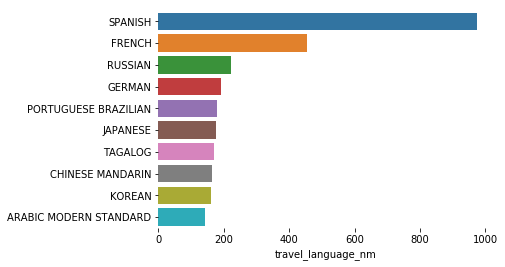

In [449]:
sns.barplot(y=lite.travel_language_nm.value_counts().nlargest(10).index, x=lite.travel_language_nm.value_counts().nlargest(10), data=tl, )
sns.despine(left=True, bottom=True)

In [446]:
lite.travel_language_nm.value_counts().nlargest(10).index

Index(['SPANISH', 'FRENCH', 'RUSSIAN', 'GERMAN', 'PORTUGUESE BRAZILIAN',
       'JAPANESE', 'TAGALOG', 'CHINESE MANDARIN', 'KOREAN',
       'ARABIC MODERN STANDARD'],
      dtype='object')

In [434]:
lite.travel_language_nm.value_counts().nlargest(10).index

Index(['SPANISH', 'FRENCH', 'RUSSIAN', 'GERMAN', 'PORTUGUESE BRAZILIAN',
       'JAPANESE', 'TAGALOG', 'CHINESE MANDARIN', 'KOREAN',
       'ARABIC MODERN STANDARD'],
      dtype='object')

In [388]:
df.groupby(['lang_event_type', 'score'])['ld_sid'].nunique().unstack()

score,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0
lang_event_type,,,,,,,,,
DLPT_LISTENING,90,165,238,509,819,1075,1861,124,78
DLPT_READING,96,170,244,445,843,1183,1813,132,97


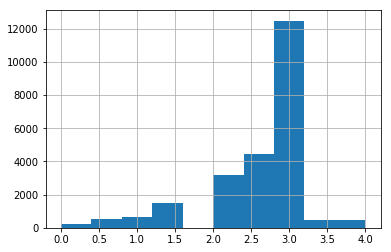

In [397]:
df.score.hist()

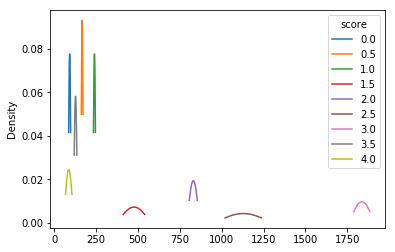

In [19]:
df.groupby(['lang_event_type', 'score'])['ld_sid'].nunique().unstack().plot(kind='kde')

In [27]:
df['date_delta'] = (df['completiondate'] - df['completiondate'].min())  / np.timedelta64(1,'D')

In [28]:
x = df[(df.ld_sid == "10A1003") & (df.lang_event_type == "DLPT_LISTENING")].date_delta

In [29]:
y = df[(df.ld_sid == "10A1003") & (df.lang_event_type == "DLPT_LISTENING")].score

In [30]:
from scipy.stats import linregress
linregress(x, y)

LinregressResult(slope=9.820432857894759e-05, intercept=-1.3019274015698268, rvalue=0.21267282087331252, pvalue=0.5827458640296894, stderr=0.00017053717445961116)

In [31]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

In [32]:
slope, intercept, r_value, p_value, std_err

(9.820432857894759e-05,
 -1.3019274015698268,
 0.21267282087331252,
 0.5827458640296894,
 0.00017053717445961116)

In [33]:
x

0    34172.0
1    34938.0
2    35328.0
3    35329.0
4    35697.0
5    36398.0
6    36412.0
7    36947.0
8    37752.0
Name: date_delta, dtype: float64

In [34]:
y

0    1.5
1    2.0
2    2.5
3    2.5
4    2.0
5    2.5
6    2.5
7    3.0
8    1.5
Name: score, dtype: float64

In [40]:
y.mean()

2.2222222222222223

In [39]:
y[1:].mean()

2.3125

In [41]:
X = x - x.mean()
Y = y - y.mean()
slope2 = (X.dot(Y)) / (X.dot(X))
print(slope2)

9.820432857894758e-05


In [42]:
slope2

9.820432857894758e-05

In [62]:
df.columns

Index(['ld_sid', 'lang_event_type', 'completiondate', 'grade', 'lang_descr',
       'score', 'date_delta'],
      dtype='object')

In [63]:
df2 = df[df.lang_event_type == 'DLPT_LISTENING'][['ld_sid', 'date_delta', 'score', 'lang_descr']]

In [66]:
df2.groupby(['lang_event_type', 'lang_descr', 'ld_sid'])['score'

SyntaxError: unexpected EOF while parsing (<ipython-input-66-97131747c178>, line 1)

In [ ]:
df = df[df.line_race != 0]

In [136]:
import scipy.stats
df2.groupby('ld_sid').apply(lambda v: score(v))

KeyError: 0

In [72]:
df2[df2.ld_sid == '18B7550']

,ld_sid,date_delta,score
23928,18B7550,37727.0,3.0


In [11]:
df.query('ld_sid == "10A1003" & lang_event_type == "DLPT_LISTENING"')['score']

0    1.5
1    2.0
2    2.5
3    2.5
4    2.0
5    2.5
6    2.5
7    3.0
8    1.5
Name: score, dtype: float64

In [13]:
test = df.query('ld_sid == "10A1003" & lang_event_type == "DLPT_LISTENING"')[['completiondate', 'score']]

In [17]:
test.set_index('completiondate', inplace=True)

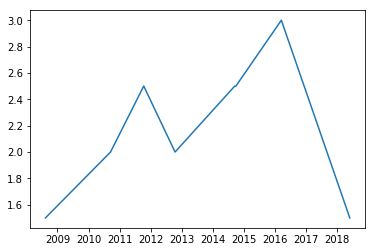

In [19]:
plt.plot(test)

In [49]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(2).mean()
    rolstd = timeseries.rolling(2).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

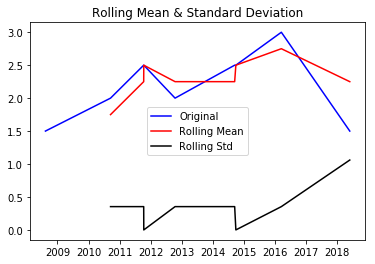

Results of Dickey-Fuller Test:


ValueError: too many values to unpack (expected 2)

In [52]:
test_stationarity(test)

In [55]:
import seaborn as sns

TypeError: regplot() missing 1 required positional argument: 'y'

AttributeError: 'DatetimeIndex' object has no attribute 'mean'

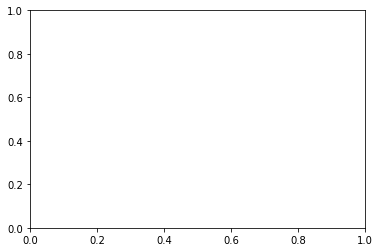

In [64]:
sns.regplot(x=test.index, y=test)

C:\Users\595217\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


ValueError: cannot label index with a null key

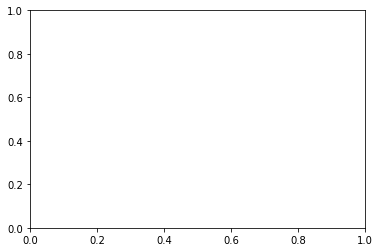

In [65]:
sns.tsplot(test)

In [66]:
data = {'date': ['2014-05-01 18:47:05.069722', '2014-05-01 18:47:05.119994', '2014-05-02 18:47:05.178768', '2014-05-02 18:47:05.230071', '2014-05-02 18:47:05.230071', '2014-05-02 18:47:05.280592', '2014-05-03 18:47:05.332662', '2014-05-03 18:47:05.385109', '2014-05-04 18:47:05.436523', '2014-05-04 18:47:05.486877'], 
        'deaths_regiment_1': [34, 43, 14, 15, 15, 14, 31, 25, 62, 41],
        'deaths_regiment_2': [52, 66, 78, 15, 15, 5, 25, 25, 86, 1],
        'deaths_regiment_3': [13, 73, 82, 58, 52, 87, 26, 5, 56, 75],
        'deaths_regiment_4': [44, 75, 26, 15, 15, 14, 54, 25, 24, 72],
        'deaths_regiment_5': [25, 24, 25, 15, 57, 68, 21, 27, 62, 5],
        'deaths_regiment_6': [84, 84, 26, 15, 15, 14, 26, 25, 62, 24],
        'deaths_regiment_7': [46, 57, 26, 15, 15, 14, 26, 25, 62, 41]}
df2 = pd.DataFrame(data, columns = ['date', 'battle_deaths', 'deaths_regiment_1', 'deaths_regiment_2',
                                   'deaths_regiment_3', 'deaths_regiment_4', 'deaths_regiment_5',
                                   'deaths_regiment_6', 'deaths_regiment_7'])
df2 = df2.set_index(df2.date)

In [75]:
sns.tsplot([df2.deaths_regiment_1, df2.deaths_regiment_2, df2.deaths_regiment_3, df2.deaths_regiment_4,
            df2.deaths_regiment_5, color="indianred")

SyntaxError: invalid syntax (<ipython-input-75-fb968d63f71b>, line 2)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23939 entries, 0 to 23938
Data columns (total 9 columns):
index              23939 non-null int64
helper             23939 non-null object
ld_sid             23939 non-null object
lang_event_type    23939 non-null object
completiondate     23929 non-null datetime64[ns]
grade              23924 non-null object
lang_descr         23939 non-null object
lang_type          23939 non-null object
score              23924 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 1.6+ MB


In [108]:
df.reset_index()

,level_0,index,helper,ld_sid,lang_event_type,completiondate,grade,lang_descr,lang_type,score
0,0,2,10A1003:3,10A1003,DLPT_LISTENING,2008-08-12,1+,SWAHILI,SELECTED,1.5
1,1,3,10A1003:4,10A1003,DLPT_LISTENING,2010-09-17,2,SWAHILI,SELECTED,2.0
2,2,1,10A1003:2,10A1003,DLPT_LISTENING,2011-10-12,2+,SWAHILI,SELECTED,2.5
3,3,0,10A1003:1,10A1003,DLPT_LISTENING,2011-10-13,2+,SWAHILI,SELECTED,2.5
4,4,7,10A1003:8,10A1003,DLPT_LISTENING,2012-10-15,2,SWAHILI,SELECTED,2.0
5,5,4,10A1003:5,10A1003,DLPT_LISTENING,2014-09-16,2+,SWAHILI,SELECTED,2.5
6,6,5,10A1003:6,10A1003,DLPT_LISTENING,2014-09-30,2+,SWAHILI,SELECTED,2.5
7,7,6,10A1003:7,10A1003,DLPT_LISTENING,2016-03-18,3,SWAHILI,SELECTED,3.0
8,8,8,10A1003:9,10A1003,DLPT_LISTENING,2018-06-01,1+,SWAHILI,SELECTED,1.5
9,9,12021,10A1003:13,10A1003,DLPT_READING,2008-08-12,2,SWAHILI,SELECTED,2.0


In [192]:
dfl = df[df.lang_event_type == 'DLPT_LISTENING'].sort_values(['ld_sid', 'completiondate'])

In [193]:
dfl.head(10)

,ld_sid,lang_event_type,completiondate,grade,lang_descr,score
0,10A1003,DLPT_LISTENING,2008-08-12,1+,SWAHILI,1.5
1,10A1003,DLPT_LISTENING,2010-09-17,2,SWAHILI,2.0
2,10A1003,DLPT_LISTENING,2011-10-12,2+,SWAHILI,2.5
3,10A1003,DLPT_LISTENING,2011-10-13,2+,SWAHILI,2.5
4,10A1003,DLPT_LISTENING,2012-10-15,2,SWAHILI,2.0
5,10A1003,DLPT_LISTENING,2014-09-16,2+,SWAHILI,2.5
6,10A1003,DLPT_LISTENING,2014-09-30,2+,SWAHILI,2.5
7,10A1003,DLPT_LISTENING,2016-03-18,3,SWAHILI,3.0
8,10A1003,DLPT_LISTENING,2018-06-01,1+,SWAHILI,1.5
18,10A1004,DLPT_LISTENING,2010-01-26,3,POLISH,3.0


In [211]:
first_dfl = dfl.groupby('ld_sid', as_index=False).apply(lambda t: t.iloc[0])

In [212]:
first_dfl.head()

,ld_sid,lang_event_type,completiondate,grade,lang_descr,score
0,10A1003,DLPT_LISTENING,2008-08-12,1+,SWAHILI,1.5
1,10A1004,DLPT_LISTENING,2010-01-26,3,POLISH,3.0
2,10A1005,DLPT_LISTENING,2010-02-04,2+,FRENCH,2.5
3,10A1006,DLPT_LISTENING,2009-08-05,0+,CHINESE MANDARIN,0.5
4,10A1008,DLPT_LISTENING,2009-08-03,2,SPANISH,2.0


In [ ]:
dfl.groupby('ld_sid', as_index=False).apply(lambda t: t.iloc[0])

In [209]:
new_dfl = dfl.groupby('ld_sid', as_index=False).apply(lambda t: t.iloc[1:]).reset_index(drop=True)

In [213]:
new_dfl.groupby('ld_sid', as_index=False).agg('mean').head()

,ld_sid,score
0,10A1003,2.312500
1,10A1004,3.000000
2,10A1005,2.285714
3,10A1006,0.375000
4,10A1008,2.111111


In [ ]:
#from scipy.stats import linregress
#linregress(a, b)

In [256]:
new_dfl.head(10)

,ld_sid,lang_event_type,completiondate,grade,lang_descr,score
0,10A1003,DLPT_LISTENING,2010-09-17,2,SWAHILI,2.0
1,10A1003,DLPT_LISTENING,2011-10-12,2+,SWAHILI,2.5
2,10A1003,DLPT_LISTENING,2011-10-13,2+,SWAHILI,2.5
3,10A1003,DLPT_LISTENING,2012-10-15,2,SWAHILI,2.0
4,10A1003,DLPT_LISTENING,2014-09-16,2+,SWAHILI,2.5
5,10A1003,DLPT_LISTENING,2014-09-30,2+,SWAHILI,2.5
6,10A1003,DLPT_LISTENING,2016-03-18,3,SWAHILI,3.0
7,10A1003,DLPT_LISTENING,2018-06-01,1+,SWAHILI,1.5
8,10A1004,DLPT_LISTENING,2011-01-05,3,POLISH,3.0
9,10A1004,DLPT_LISTENING,2012-01-20,3,POLISH,3.0


In [275]:
rolling = new_dfl.groupby('ld_sid')['score'].rolling(2).mean().reset_index()

In [281]:
rolling_final = rolling.groupby('ld_sid')['score'].last().reset_index()

In [283]:
rolling_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Data columns (total 2 columns):
ld_sid    2492 non-null object
score     1955 non-null float64
dtypes: float64(1), object(1)
memory usage: 39.0+ KB


In [222]:
top_score = new_dfl.groupby('ld_sid', as_index=False)['score'].max()

In [326]:
new_dfl.groupby('ld_sid')['score'].count().head()

ld_sid
10A1003    8
10A1004    7
10A1005    7
10A1006    4
10A1008    9
Name: score, dtype: int64

In [325]:
new_dfl.groupby('ld_sid', as_index=False)['score'].rolling(window=2).mean()

0     0        NaN
      1       2.25
      2       2.50
      3       2.25
      4       2.25
      5       2.50
      6       2.75
      7       2.25
1     8        NaN
      9       3.00
      10      3.00
      11      3.00
      12      3.00
      13      3.00
      14      3.00
2     15       NaN
      16      2.00
      17      2.00
      18      2.50
      19      2.50
      20      2.50
      21      2.25
3     22       NaN
      23      0.25
      24      0.50
      25      0.50
4     26       NaN
      27      2.00
      28      2.00
      29      2.00
              ... 
2466  9085     NaN
2467  9086     NaN
2468  9087     NaN
      9088    1.75
2469  9089     NaN
2470  9090     NaN
2471  9091     NaN
      9092    2.75
2472  9093     NaN
2473  9094     NaN
2474  9095     NaN
2475  9096     NaN
      9097    2.75
2476  9098     NaN
2477  9099     NaN
2478  9100     NaN
2479  9101     NaN
2480  9102     NaN
2481  9103     NaN
2482  9104     NaN
2483  9105     NaN
2484  9106  

In [314]:
new_dfl.groupby('ld_sid')['score'].rolling(2).mean()

ld_sid       
10A1003  0        NaN
         1       2.25
         2       2.50
         3       2.25
         4       2.25
         5       2.50
         6       2.75
         7       2.25
10A1004  8        NaN
         9       3.00
         10      3.00
         11      3.00
         12      3.00
         13      3.00
         14      3.00
10A1005  15       NaN
         16      2.00
         17      2.00
         18      2.50
         19      2.50
         20      2.50
         21      2.25
10A1006  22       NaN
         23      0.25
         24      0.50
         25      0.50
10A1008  26       NaN
         27      2.00
         28      2.00
         29      2.00
                 ... 
18B6205  9085     NaN
18B6229  9086     NaN
18B6231  9087     NaN
         9088    1.75
18B6245  9089     NaN
18B6268  9090     NaN
18B6269  9091     NaN
         9092    2.75
18B6273  9093     NaN
18B6285  9094     NaN
18B6311  9095     NaN
18B6324  9096     NaN
         9097    2.75
18B6327  9098     

In [293]:
df[(df.ld_sid == '10A1003') & (df.lang_event_type == 'DLPT_LISTENING')]

,ld_sid,lang_event_type,completiondate,grade,lang_descr,score
0,10A1003,DLPT_LISTENING,2008-08-12,1+,SWAHILI,1.5
1,10A1003,DLPT_LISTENING,2010-09-17,2,SWAHILI,2.0
2,10A1003,DLPT_LISTENING,2011-10-12,2+,SWAHILI,2.5
3,10A1003,DLPT_LISTENING,2011-10-13,2+,SWAHILI,2.5
4,10A1003,DLPT_LISTENING,2012-10-15,2,SWAHILI,2.0
5,10A1003,DLPT_LISTENING,2014-09-16,2+,SWAHILI,2.5
6,10A1003,DLPT_LISTENING,2014-09-30,2+,SWAHILI,2.5
7,10A1003,DLPT_LISTENING,2016-03-18,3,SWAHILI,3.0
8,10A1003,DLPT_LISTENING,2018-06-01,1+,SWAHILI,1.5


In [294]:
df.score[(df.ld_sid == '10A1003') & (df.lang_event_type == 'DLPT_LISTENING')]

0    1.5
1    2.0
2    2.5
3    2.5
4    2.0
5    2.5
6    2.5
7    3.0
8    1.5
Name: score, dtype: float64

In [295]:
sample = df.score[(df.ld_sid == '10A1003') & (df.lang_event_type == 'DLPT_LISTENING')]

In [296]:
sample.iloc[1:].mean()

2.3125

In [103]:
z = df.score[(df.ld_sid == '10A1003') & (df.lang_event_type == 'DLPT_LISTENING')]

In [144]:
def tally(x):
#    i = []
    if len(x) == 1:
        return 0
    else:
        for i in x:
            return x[0], x[1:].mean()

In [146]:
tally(z)

(1.5, 2.3125)

In [147]:
data = np.array([1.5])
t = pd.Series(data)
tally(t)

0

In [167]:
group = df.groupby(['lang_event_type', 'lang_descr', 'ld_sid'])['score']

In [168]:
list(group)

[(('DLPT_LISTENING', 'AFRIKAANS', '11A2138'), 2545    2.0
  2546    2.0
  2547    2.0
  2548    2.0
  2549    2.0
  2550    3.0
  Name: score, dtype: float64),
 (('DLPT_LISTENING', 'AFRIKAANS', '12B4656'), 10511    3.0
  10512    3.0
  10513    3.5
  10514    3.5
  10515    3.0
  10516    3.5
  Name: score, dtype: float64),
 (('DLPT_LISTENING', 'ALBANIAN', '13A4747'), 10642    2.5
  10643    3.0
  10644    3.0
  10645    3.0
  10646    3.0
  10647    3.0
  Name: score, dtype: float64),
 (('DLPT_LISTENING', 'ALBANIAN', '15B2587'), 19706    2.5
  19707    3.0
  19708    3.0
  Name: score, dtype: float64),
 (('DLPT_LISTENING', 'ALBANIAN', '16B4170'), 21673    2.5
  21674    3.0
  21675    2.5
  Name: score, dtype: float64),
 (('DLPT_LISTENING', 'ALBANIAN', '17B5437'), 22639    2.0
  22640    2.0
  Name: score, dtype: float64),
 (('DLPT_LISTENING', 'AMHARIC', '12B4433'), 9747    3.0
  9748    3.5
  Name: score, dtype: float64),
 (('DLPT_LISTENING', 'AMHARIC', '13A4728'), 10611    3.0
  Nam

In [162]:
group.describe()

count      mean       std  \
lang_event_type lang_descr             ld_sid                               
DLPT_LISTENING  AFRIKAANS              11A2138    6.0  2.166667  0.408248   
                                       12B4656    6.0  3.250000  0.273861   
                ALBANIAN               13A4747    6.0  2.916667  0.204124   
                                       15B2587    3.0  2.833333  0.288675   
                                       16B4170    3.0  2.666667  0.288675   
                                       17B5437    2.0  2.000000  0.000000   
                AMHARIC                12B4433    2.0  3.250000  0.353553   
                                       13A4728    1.0  3.000000       NaN   
                                       13A4797    6.0  2.750000  0.273861   
                                       13A4824    2.0  3.000000  0.000000   
                                       13A5070    4.0  2.875000  0.250000   
                                       13A5233    4.0  2.250000  1.500000   
                                       13B5489    3.0  3.000000  0.000000   
                                       14B0985    3.0  3.166667  0.288675   
                                       15B1601    4.0  3.000000  0.000000   
                                       15B2184    3.0  3.166667  0.288675   
                                       16B4110    2.0  3.000000  0.000000   
                                       17B5047    1.0  3.000000       NaN   
                                       17B5713    1.0  3.000000       NaN   
                ARABIC EGYPTIAN        13A5289    7.0  0.785714  0.267261   
                                       13B5403    6.0  2.500000  0.547723   
                                       15B1957    2.0  3.000000  0.000000   
                                       15B2128    5.0  2.400000  0.418330   
                                       16B3428    1.0  2.500000       NaN   
                                       17B4972    2.0  2.250000  0.353553   
                ARABIC MODERN STANDARD 10A1017    1.0  0.500000       NaN   
                                       10A1020    9.0  2.888889  0.220479   
                                       10A1029   10.0  2.350000  0.474342   
                                       10A1038    4.0  1.750000  0.957427   
                                       10A1081    5.0  2.200000  0.273861   
...                                               ...       ...       ...   
DLPT_READING    VIETNAMESE HANOI       11B3303    6.0  3.000000  0.000000   
                                       11B3471    9.0  0.722222  0.263523   
                                       11B3651    8.0  3.000000  0.000000   
                                       12B4263    7.0  3.000000  0.000000   
                                       12B4286   10.0  3.000000  0.000000   
                                       12B4504    5.0  3.000000  0.000000   
                                       13A4784    7.0  2.785714  0.393398   
                                       13A4849    6.0  3.000000  0.000000   
                                       13A5087    6.0  2.333333  0.516398   
                                       13A5119    7.0  3.000000  0.000000   
                                       13A5351    6.0  3.000000  0.000000   
                                       13B5452    5.0  3.000000  0.000000   
                                       14B0015    6.0  3.000000  0.000000   
                                       14B0536    5.0  3.000000  0.000000   
                                       14B1977    5.0  3.000000  0.000000   
                                       14B2020    5.0  3.000000  0.000000   
                                       14B2092    4.0  3.000000  0.000000   
                                       14B2348    3.0  2.666667  0.577350   
                                       14B2472    3.0  3.000000  0.000000   
                                       14B25

In [151]:
df.groupby(['lang_event_type', 'lang_descr', 'ld_sid'])['score'].agg('last')

lang_event_type  lang_descr              ld_sid 
DLPT_LISTENING   AFRIKAANS               11A2138    3.0
                                         12B4656    3.5
                 ALBANIAN                13A4747    3.0
                                         15B2587    3.0
                                         16B4170    2.5
                                         17B5437    2.0
                 AMHARIC                 12B4433    3.5
                                         13A4728    3.0
                                         13A4797    3.0
                                         13A4824    3.0
                                         13A5070    3.0
                                         13A5233    3.0
                                         13B5489    3.0
                                         14B0985    3.5
                                         15B1601    3.0
                                         15B2184    3.5
                                         16B4110    3.0